J1J2 model

In [1]:
import quimb.tensor as qtn
import quimb as qu

import netket as nk
from netket.graph import Lattice
from vmc_torch.hamiltonian import spin_Heisenberg_square_lattice
import numpy as np
from math import pi
from autoray import do

ndim = 2
Lx = 4
Ly = 4
L = 4
pbc = False
total_sz = 0.0
print(f"Total Sz = {total_sz}")
D = 2

basis = np.array([
     [1.0,0.0],
     [0.0,1.0],
 ])
custom_edges = [
     (0, 0, [1.0,0.0], 0),
     (0, 0, [0.0,1.0], 0),
     (0, 0, [1.0, 1.0], 1),
     (0, 0, [1.0, -1.0], 1),
 ]

g = Lattice(basis_vectors=basis, pbc=False, extent=[Lx, Ly],
     custom_edges=custom_edges)

n = g.n_nodes
hi = nk.hilbert.Spin(s=1/2, total_sz=0.0, N=n)
# Heisenberg with coupling J=1.0 for nearest neighbors
# and J=0.5 for next-nearest neighbors
H = nk.operator.Heisenberg(hilbert=hi, graph=g, J=(1.0,0.5)) # In Netket, the spin operators are Pauli matrices, while in Quimb they are 1/2*Pauli matrices
# ham0 = spin_Heisenberg_square_lattice(Lx, Ly, J=1.0, pbc=pbc,total_sz=total_sz)
# hi0 = ham0.hilbert

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total Sz = 0.0


In [2]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)
print(exact_gs_energy/(Lx*Ly)/4)

The exact ground-state energy is E0= -30.02222780032426
-0.46909730938006655


In [3]:
# PEPS tensor network
psi = qtn.PEPS.rand(Lx=Lx, Ly=Ly, bond_dim=D, phys_dim=2) # initialization from PEPS
J1=1.0
J2=0.5
# ham = qtn.ham_2d_heis(Lx=Lx, Ly=Ly, j=4*J)
ham = qtn.ham_2d_j1j2(Lx, Ly, j1=J1, j2=J2)
# su = qtn.tensor_arbgeom_tebd.SimpleUpdateGen(
#     psi, 
#     ham,
#     compute_energy_every=10,
#     compute_energy_per_site=True,
# )

su = qtn.tensor_2d_tebd.SimpleUpdate(
    psi, 
    ham,
    D=D,
    compute_energy_every=100,
    compute_energy_per_site=True,
)

for tau in [1.0, 0.3, 0.1, 0.03, 0.01]:
    su.evolve(100, tau=tau)
psi_su = su.state

peps = su.get_state()
peps.equalize_norms_(value=1)

# save the state
params, skeleton = qtn.pack(peps)

# import os
# import pickle
# os.makedirs(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}', exist_ok=True)

# with open(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/peps_skeleton.pkl', 'wb') as f:
#     pickle.dump(skeleton, f)
# with open(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/peps_su_params.pkl', 'wb') as f:
#     pickle.dump(params, f)

  0%|          | 0/100 [00:00<?, ?it/s]

n=500, tau=0.0100, energy~-0.428963: 100%|##########| 100/100 [00:03<00:00, 32.64it/s]


In [11]:
peps.compute_local_expectation(ham.terms, normalized=True, max_bond=64)*4

-27.45362140231828

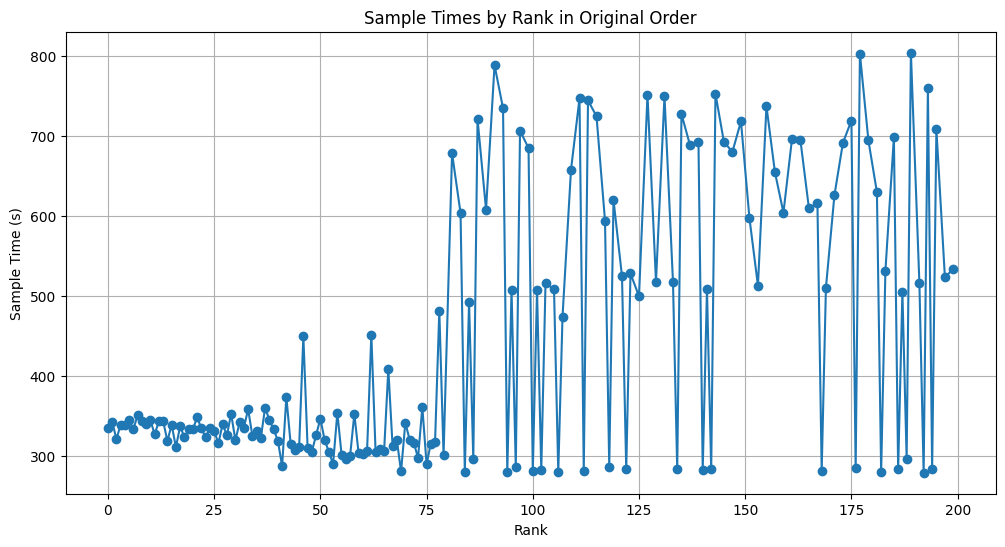

In [69]:
import matplotlib.pyplot as plt

# Data for ranks and their respective sample times
ranks = [
    182, 192, 94, 69, 84, 106, 100, 112, 168, 102, 140, 142, 186, 134, 122, 194,
    176, 118, 96, 41, 75, 53, 188, 86, 56, 73, 57, 79, 55, 60, 59, 63, 52, 48, 65,
    61, 44, 64, 47, 45, 16, 67, 43, 76, 26, 72, 77, 14, 40, 30, 68, 51, 71, 2, 36,
    18, 23, 34, 28, 49, 11, 25, 35, 19, 6, 20, 39, 22, 0, 24, 32, 17, 4, 15, 3, 9,
    27, 70, 31, 1, 12, 13, 8, 5, 10, 38, 50, 21, 7, 58, 29, 54, 33, 37, 74, 42, 66,
    46, 62, 107, 78, 85, 125, 187, 101, 141, 95, 105, 169, 153, 191, 103, 133, 129,
    197, 121, 123, 183, 199, 117, 151, 83, 159, 89, 165, 167, 119, 171, 181, 157,
    109, 81, 147, 99, 137, 173, 145, 139, 179, 163, 161, 185, 97, 195, 149, 175,
    87, 115, 135, 93, 155, 113, 111, 131, 127, 143, 193, 91, 177, 189
]

sample_times = [
    278.854216159, 278.538513765, 279.436807581, 280.122696049, 279.769310964, 
    279.691502842, 280.615187612, 280.423007931, 281.026449412, 281.829751019,
    282.274696782, 282.790175918, 282.597353659, 282.723467313, 282.778106554,
    282.863134734, 284.131574687, 285.428228352, 285.325657375, 286.810072018,
    289.294060318, 289.519358256, 296.100032479, 295.384199129, 296.346050697,
    297.132632692, 299.583352244, 300.901265036, 300.932328147, 302.385905894,
    303.07316608, 304.49432865, 304.874926879, 304.963520969, 305.208310385,
    306.040021162, 306.96165939, 308.550026387, 309.949116198, 310.224993483,
    310.589233869, 311.816930008, 314.92184678, 315.108761909, 315.333047699,
    315.878605587, 317.343996028, 318.206464648, 318.570231386, 319.121799299,
    319.277008913, 319.849603508, 320.127673512, 320.532952573, 322.539666403,
    322.742523385, 322.740549476, 324.8592434, 325.166029464, 325.372286091,
    326.676468888, 330.956972735, 330.913559061, 332.799348511, 333.018747723,
    333.198885086, 333.219645255, 334.00006178, 334.538798767, 334.555826923,
    335.010106276, 336.872290584, 337.822507298, 338.700094856, 338.904712994,
    339.269282172, 339.303375583, 341.222054835, 341.886545062, 342.664754793,
    342.831862577, 343.144369219, 343.821933798, 344.008419197, 344.26665297,
    344.59096688, 346.281301054, 347.782167627, 350.866074187, 352.217689494,
    352.49446435, 353.725667667, 358.085285865, 360.048311161, 360.944671438,
    373.538036967, 408.152953714, 449.399758638, 451.427146305, 474.064208968,
    481.355831051, 492.437331785, 499.482745662, 504.521210734, 506.9496343,
    508.301519258, 507.776823702, 508.033290632, 510.176572939, 512.800454624,
    515.974533524, 516.33192186, 517.545086529, 517.641811498, 523.682361302,
    524.507937967, 528.173797487, 531.382107089, 533.579759311, 594.228444404,
    597.385229863, 603.800032003, 604.185699689, 608.077280182, 609.739022154,
    615.875188707, 620.312441826, 626.033678266, 630.04434697, 654.904125674,
    658.254764114, 678.690431073, 680.618045032, 685.128244745, 688.950039806,
    691.71567425, 692.460891137, 692.88556795, 694.698706033, 694.757172361,
    695.951551564, 698.720203999, 707.008206171, 708.81798298, 718.539983256,
    719.587550234, 721.383786256, 725.080664475, 727.74374158, 734.93182181,
    737.662728943, 744.757875511, 747.341446179, 750.285248652, 751.769674503,
    753.267583441, 760.590802455, 789.120745565, 803.247478134, 804.574275229
]

# Plotting the sample times in rank order
plt.figure(figsize=(12, 6))
# sort the sample times by rank using sort
sample_times = [x for _, x in sorted(zip(ranks, sample_times))]
ranks = sorted(ranks)
plt.plot(ranks, sample_times, '-o')
plt.xlabel('Rank')
plt.ylabel('Sample Time (s)')
plt.title('Sample Times by Rank in Original Order')
plt.grid(True)
plt.show()


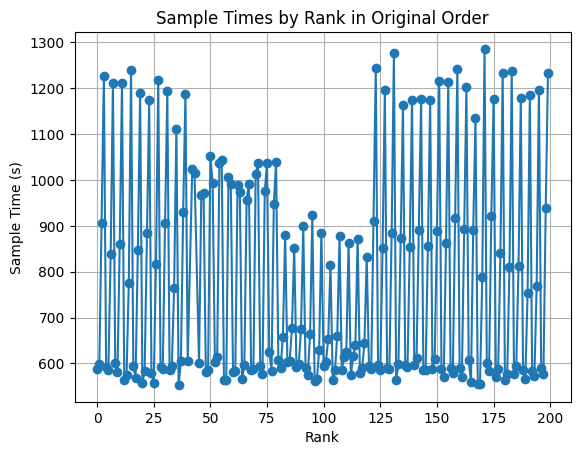

In [71]:
import re
data = """Rank 36, sample time: 553.07622054
Rank 96, sample time: 561.722705764
Rank 104, sample time: 562.726074333
Rank 168, sample time: 554.049968595
Rank 169, sample time: 554.520749932

Sampling starts for rank 0...:  94%|█████████▍| 30/32 [07:40<00:30, 15.16s/it, Time per sample for each rank=6.99]Rank 57, sample time: 563.983147536
Rank 56, sample time: 564.28405697
Rank 97, sample time: 565.199357709
Rank 25, sample time: 556.430123581
Rank 20, sample time: 556.518677734
Rank 64, sample time: 565.955023483
Rank 165, sample time: 559.039912047

Sampling starts for rank 0...:  94%|█████████▍| 30/32 [07:47<00:30, 15.16s/it, Time per sample for each rank=7.04]Rank 180, sample time: 563.097291792
Rank 132, sample time: 563.676824704
Rank 12, sample time: 564.841929431
Rank 112, sample time: 573.880182974
Rank 93, sample time: 575.057352889
Rank 189, sample time: 566.681425767
Rank 73, sample time: 577.540898163
Rank 17, sample time: 569.218187759

Sampling starts for rank 0...:  97%|█████████▋| 31/32 [07:55<00:15, 15.25s/it, Time per sample for each rank=7.04]Rank 161, sample time: 570.551061213
Rank 116, sample time: 579.412092947
Rank 176, sample time: 571.088866633
Rank 153, sample time: 571.393290301
Rank 193, sample time: 571.733687724
Rank 48, sample time: 581.593326517
Rank 60, sample time: 581.866486639
Rank 13, sample time: 574.173705534
Rank 77, sample time: 583.526267286
Rank 61, sample time: 583.65135681
Rank 181, sample time: 575.8172315
Rank 68, sample time: 585.001040084
Rank 108, sample time: 585.004738504
Rank 105, sample time: 585.232556874
Rank 197, sample time: 576.54805354

Sampling starts for rank 0...:  97%|█████████▋| 31/32 [08:02<00:15, 15.25s/it, Time per sample for each rank=6.61]Rank 184, sample time: 577.204779075
Rank 49, sample time: 586.301724461
Rank 69, sample time: 587.889370897
Rank 24, sample time: 579.268505125
Rank 157, sample time: 579.427991477
Rank 117, sample time: 589.084858915
Rank 92, sample time: 589.487765385
Rank 81, sample time: 590.723656478
Rank 9, sample time: 581.93689334
Rank 173, sample time: 583.033515778
Rank 88, sample time: 592.408916467
Rank 192, sample time: 583.592471963
Rank 21, sample time: 584.306563417
Rank 100, sample time: 593.975419188
Rank 32, sample time: 585.773102994
Rank 72, sample time: 594.846463304
Rank 144, sample time: 585.961518021
Rank 5, sample time: 585.961414032
Rank 145, sample time: 585.970066792
Rank 125, sample time: 586.034425368
Rank 188, sample time: 586.377048031

Sampling starts for rank 0...: 100%|██████████| 32/32 [08:11<00:00, 15.62s/it, Time per sample for each rank=6.61]
Sampling starts for rank 0...: 100%|██████████| 32/32 [08:11<00:00, 15.37s/it, Time per sample for each rank=6.61]
Rank 0, sample time: 586.789691765
Rank 177, sample time: 586.997306456
Rank 129, sample time: 587.370214463
Rank 65, sample time: 596.432817318
Rank 152, sample time: 588.113633091
Rank 121, sample time: 588.393968799
Rank 29, sample time: 588.492711082
Rank 148, sample time: 588.732336438
Rank 89, sample time: 597.795201569
Rank 160, sample time: 590.469655517
Rank 196, sample time: 590.633730526
Rank 128, sample time: 590.832727678
Rank 156, sample time: 590.86250869
Rank 137, sample time: 591.549287384
Rank 4, sample time: 592.373415819
Rank 45, sample time: 601.504859858
Rank 28, sample time: 592.634393159
Rank 33, sample time: 593.562302734
Rank 52, sample time: 602.861048443
Rank 16, sample time: 594.54748509
Rank 101, sample time: 603.394908095
Rank 185, sample time: 594.774243986
Rank 84, sample time: 603.647686374
Rank 120, sample time: 595.095085714
Rank 124, sample time: 596.483823929
Rank 85, sample time: 605.411465576
Rank 136, sample time: 597.038168136
Rank 140, sample time: 597.042702447
Rank 40, sample time: 606.053755649
Rank 80, sample time: 606.751890989
Rank 1, sample time: 598.479709513
Rank 133, sample time: 599.592634364
Rank 172, sample time: 601.480349745
Rank 8, sample time: 601.762481767
Rank 53, sample time: 612.929473415
Rank 37, sample time: 605.331867995
Rank 109, sample time: 614.674214363
Rank 113, sample time: 615.294324297
Rank 164, sample time: 608.090315749
Rank 149, sample time: 610.407595431
Rank 141, sample time: 611.654851272
Rank 76, sample time: 625.779400548
Rank 110, sample time: 625.646490749
Rank 98, sample time: 628.172320133
Rank 114, sample time: 640.096473948
Rank 118, sample time: 645.182055027
Rank 102, sample time: 653.065086484
Rank 82, sample time: 658.442673894
Rank 106, sample time: 660.291754119
Rank 94, sample time: 663.583832162
Rank 90, sample time: 675.362893447
Rank 86, sample time: 676.214777863
Rank 190, sample time: 752.920496864
Rank 34, sample time: 765.397928138
Rank 194, sample time: 768.994073782
Rank 14, sample time: 775.889331404
Rank 170, sample time: 787.636412049
Rank 103, sample time: 815.248684747
Rank 182, sample time: 809.908513272
Rank 186, sample time: 812.172709514
Rank 26, sample time: 816.743741826
Rank 119, sample time: 832.928732931
Rank 6, sample time: 838.380799045
Rank 178, sample time: 839.787738909
Rank 87, sample time: 852.011058567
Rank 18, sample time: 848.252859605
Rank 126, sample time: 852.223856609
Rank 138, sample time: 854.786228216
Rank 146, sample time: 855.584942934
Rank 111, sample time: 863.485492174
Rank 10, sample time: 860.754869194
Rank 154, sample time: 862.947424632
Rank 115, sample time: 871.917266147
Rank 107, sample time: 877.370716154
Rank 83, sample time: 879.657735074
Rank 134, sample time: 874.293508975
Rank 99, sample time: 884.821809422
Rank 22, sample time: 883.555207951
Rank 130, sample time: 885.019089698
Rank 150, sample time: 889.211214236
Rank 142, sample time: 889.848581532
Rank 166, sample time: 890.18104791
Rank 91, sample time: 898.700599907
Rank 162, sample time: 893.021025945
Rank 2, sample time: 906.806799877
Rank 30, sample time: 906.952825401
Rank 122, sample time: 910.201731867
Rank 95, sample time: 923.928957948
Rank 158, sample time: 917.213842959
Rank 174, sample time: 922.00087455
Rank 38, sample time: 931.132928444
Rank 78, sample time: 946.632848412
Rank 198, sample time: 939.744588329
Rank 66, sample time: 956.969338761
Rank 46, sample time: 966.822864422
Rank 47, sample time: 971.161523119
Rank 63, sample time: 972.707929342
Rank 74, sample time: 974.87737269
Rank 62, sample time: 988.330865256
Rank 67, sample time: 990.835931573
Rank 59, sample time: 991.948868613
Rank 51, sample time: 992.76357192
Rank 58, sample time: 1005.706966863
Rank 70, sample time: 1012.610923978
Rank 43, sample time: 1015.1836469
Rank 42, sample time: 1024.354944634
Rank 71, sample time: 1036.241504758
Rank 54, sample time: 1037.035338918
Rank 75, sample time: 1036.456492841
Rank 79, sample time: 1039.1759514
Rank 55, sample time: 1044.063881029
Rank 50, sample time: 1053.293329385
Rank 35, sample time: 1111.912475188
Rank 167, sample time: 1135.346734595
Rank 135, sample time: 1163.441112859
Rank 23, sample time: 1173.435577732
Rank 139, sample time: 1175.230264388
Rank 147, sample time: 1175.041070755
Rank 143, sample time: 1175.734283721
Rank 175, sample time: 1177.070388308
Rank 187, sample time: 1177.74156236
Rank 191, sample time: 1184.785541304
Rank 39, sample time: 1187.830197504
Rank 19, sample time: 1188.816416444
Rank 31, sample time: 1194.826913703
Rank 127, sample time: 1195.679674876
Rank 195, sample time: 1197.257685076
Rank 163, sample time: 1201.679506216
Rank 7, sample time: 1212.265456141
Rank 11, sample time: 1212.378130352
Rank 155, sample time: 1214.578223107
Rank 151, sample time: 1215.078406657
Rank 27, sample time: 1218.019422786
Rank 3, sample time: 1227.699068495
Rank 179, sample time: 1233.943752745
Rank 199, sample time: 1234.096327684
Rank 183, sample time: 1237.861050293
Rank 15, sample time: 1240.660959217
Rank 159, sample time: 1242.093679597
Rank 123, sample time: 1243.334679736
Rank 131, sample time: 1276.964569684
Rank 171, sample time: 1285.744368501"""

# Using regular expressions to extract rank and time pairs
pattern = r"Rank (\d+), sample time: ([\d.]+)"
matches = re.findall(pattern, data)

# Converting extracted matches to a list of tuples with rank as int and sample time as float
ranks = []
sample_times = []
for match in matches:
    ranks.append(int(match[0]))
    sample_times.append(float(match[1]))

import matplotlib.pyplot as plt
# sort the sample times by rank using sort
sample_times = [x for _, x in sorted(zip(ranks, sample_times))]
ranks = sorted(ranks)
plt.plot(ranks, sample_times, '-o')
plt.xlabel('Rank')
plt.ylabel('Sample Time (s)')
plt.title('Sample Times by Rank in Original Order')
plt.grid(True)
plt.show()

Heisenberg model

In [36]:
import quimb.tensor as qtn
import quimb as qu

import netket as nk
from vmc_torch.hamiltonian import spin_Heisenberg_square_lattice
import numpy as np
from math import pi
from autoray import do

ndim = 2
Lx = 2
Ly = 2
L = 2
pbc = False
total_sz = 0.0
print(f"Total Sz = {total_sz}")
D = 4

# Build square lattice with nearest and next-nearest neighbor edges
# lattice = nk.graph.Square(L, max_neighbor_order=1, pbc=False)
# g = lattice = nk.graph.Hypercube(L, ndim, pbc=pbc)
g = lattice = nk.graph.Grid([Lx, Ly], pbc=pbc)
# g = lattice = nk.graph.Pyrochlore([L, L, L], pbc=pbc)

n = lattice.n_nodes
hi = nk.hilbert.Spin(s=1 / 2, total_sz=0.0, N=n)
# Heisenberg with coupling J=1.0 for nearest neighbors
# and J=0.5 for next-nearest neighbors
# H = nk.operator.Ising(hilbert=hi, graph=lattice, J=1.0, h=1.0)
H = nk.operator.Heisenberg(hilbert=hi, graph=lattice, J=1.0, sign_rule=False) # In Netket, the spin operators are Pauli matrices, while in Quimb they are 1/2*Pauli matrices

ham0 = spin_Heisenberg_square_lattice(Lx, Ly, J=1.0, pbc=pbc,total_sz=total_sz)
hi0 = ham0.hilbert

Total Sz = 0.0


In [37]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)
print(exact_gs_energy/(Lx*Ly)/4)

The exact ground-state energy is E0= -7.999999999999999
-0.49999999999999994


In [38]:
# PEPS tensor network
psi = qtn.PEPS.rand(Lx=Lx, Ly=Ly, bond_dim=D, phys_dim=2) # initialization from PEPS
J=1.0
ham = qtn.ham_2d_heis(Lx=Lx, Ly=Ly, j=J)
su = qtn.tensor_arbgeom_tebd.SimpleUpdateGen(
    psi, 
    ham,
    compute_energy_every=10,
    compute_energy_per_site=True,
)
for tau in [1.0, 0.3, 0.1, 0.03, 0.01]:
    su.evolve(100, tau=tau)
psi_su = su.state

# peps = su.get_state()
# peps.equalize_norms_(value=1)

# # save the state
# params, skeleton = qtn.pack(peps)

# import os
# import pickle
# os.makedirs(f'../../data/{Lx}x{Ly}/J={J}/D={D}', exist_ok=True)

# with open(f'../../data/{Lx}x{Ly}/J={J}/D={D}/peps_skeleton.pkl', 'wb') as f:
#     pickle.dump(skeleton, f)
# with open(f'../../data/{Lx}x{Ly}/J={J}/D={D}/peps_su_params.pkl', 'wb') as f:
#     pickle.dump(params, f)
    

n=0, tau=0.0000, energy~-0.030482:   0%|          | 0/100 [00:00<?, ?it/s]

n=500, tau=0.0100, energy~-0.439450: 100%|##########| 100/100 [00:00<00:00, 113.96it/s]


In [189]:
def from_netket_to_quimb_spin_config(config):
    """From (-1,1) to (0,1) basis"""
    def func(x):
        return do('array',(x + 1) / 2, dtype=int)
    if len(config.shape) == 1:
        return func(config)
    else:
        return np.array([func(c) for c in config])

def get_amp(psi, config):
    return psi.isel({psi.site_inds[i]: int(s) for i, s in enumerate(config)})

def to_array(psi):
    return psi.to_dense()

def to_array_amps(psi, configs_netket):
    configs = from_netket_to_quimb_spin_config(configs_netket)
    return np.array([get_amp(psi, config).contract() for config in configs])

def to_array_config_dict(psi, configs_netket):
    configs = from_netket_to_quimb_spin_config(configs_netket)
    return {tuple(config): get_amp(psi, config).contract() for config in configs}

In [190]:
psi_vec = to_array_amps(psi_su, hi.all_states())
# psi_dict = to_array_config_dict(psi_su, hi.all_states())

In [192]:
hamiltonian = H.to_dense()

print("Energy from Quimb:", np.vdot(psi_vec, hamiltonian @ psi_vec).real / np.vdot(psi_vec, psi_vec).real/(Lx*Ly)/4)

Energy from Quimb: -0.528558043149109


In [193]:
# psi_su.view_as_(qtn.PEPS)
psi_su.compute_local_expectation(ham.terms, normalized=True, max_bond=128)/(Lx*Ly)/4

-0.49680707385756656

In [33]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
import numpy as np
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import pickle


# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

from vmc_torch.experiment.tn_model import PEPS_model, PEPS_NN_Model, init_weights_to_zero, PEPS_NNproj_Model, PEPS_delocalized_Model
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless, MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import TrivialPreconditioner, SignedSGD, SGD, SR
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import spin_J1J2_square_lattice
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.utils import closest_divisible

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(10)
Ly = int(10)
J1 = 1.0
J2 = 0.5
H = spin_J1J2_square_lattice(Lx, Ly, J1, J2, total_sz=0.0) 
graph = H.graph
# TN parameters
D = 3
chi = 2
chi_nn = 2
dtype=torch.float64

# Load PEPS
skeleton = pickle.load(open(f"../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/peps_skeleton.pkl", "rb"))
peps_params = pickle.load(open(f"../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/peps_su_params.pkl", "rb"))
peps = qtn.unpack(peps_params, skeleton)
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))

# VMC sample size
N_samples = int(6)
N_samples = closest_divisible(N_samples, SIZE)
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

model0 = PEPS_model(peps, max_bond=chi)
model = PEPS_delocalized_Model(peps, max_bond=chi, diag=False)
# model = PEPS_NN_Model(peps, max_bond=chi_nn, nn_eta=1.0, nn_hidden_dim=L**2)
# model = PEPS_NNproj_Model(peps, max_bond=chi_nn, nn_eta=1.0, nn_hidden_dim=L**2)
# model.apply(init_weights_to_zero)
model_names = {
    PEPS_model: 'PEPS',
    PEPS_delocalized_Model: 'PEPS_delocalized_diag='+str(model.diag) if type (model)==PEPS_delocalized_Model else None,
    PEPS_NN_Model: 'PEPS_NN',
    PEPS_NNproj_Model: 'PEPS_NNproj'
}
model_name = model_names.get(type(model), 'UnknownModel')

init_step = 0
final_step = 200
total_steps = final_step - init_step
if init_step != 0:
    saved_model_params = torch.load(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/{model_name}/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# optimizer = SignedSGD(learning_rate=0.05)
learning_rate = 5e-2
optimizer = SGD(learning_rate=learning_rate)
sampler = MetropolisExchangeSamplerSpinless(H.hilbert, graph, N_samples=N_samples, burn_in_steps=1, reset_chain=False, random_edge=True, equal_partition=False, dtype=dtype)
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=5e-2, iter_step=1e5, dtype=dtype)
vmc = VMC(hamiltonian=H, variational_state=variational_state, optimizer=optimizer, preconditioner=preconditioner)

if __name__ == "__main__":
    torch.autograd.set_detect_anomaly(False)
    if RANK == 0:
        # print training information
        print(f"Running VMC for {model_name}")
        print(f"Optimizer: {optimizer}")
        print(f"Preconditioner: {preconditioner}")
        print(f"Sampler: {sampler}")
        print(f'2D j1j2 model on {Lx}x{Ly} lattice with J1={J1}, J2={J2}')
        print(f"Running {total_steps} steps from {init_step} to {final_step}")
        print(f'Learning rate: {learning_rate}')
        print(f'Sample size: {N_samples}')
        print(f'fPEPS bond dimension: {D}, max bond: {chi}')
    # os.makedirs(f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/{model_name}/chi={chi}/', exist_ok=True)
    # vmc.run(init_step, init_step+total_steps, tmpdir=f'../../data/{Lx}x{Ly}/J1={J1}_J2={J2}/D={D}/{model_name}/chi={chi}/')



Running VMC for PEPS_delocalized_diag=False
Optimizer: <vmc_torch.optimizer.SGD object at 0x7f5a201feca0>
Preconditioner: <vmc_torch.optimizer.SR object at 0x7f5a201fefa0>
Sampler: <vmc_torch.sampler.MetropolisExchangeSamplerSpinless object at 0x7f5a202e4310>
2D j1j2 model on 10x10 lattice with J1=1.0, J2=0.5
Running 200 steps from 0 to 200
Learning rate: 0.05
Sample size: 6
fPEPS bond dimension: 3, max bond: 2


In [34]:
%%timeit
random_config = H.hilbert.random_state(2)
variational_state.amplitude(random_config)

76.8 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [161]:
batchsize = 500
# samples = sampler.sample(H, variational_state, chain_length=batchsize)
# samples[0]/batchsize/L**2/4
samples = sampler.sample_expectation(variational_state, H, chain_length=batchsize)

In [170]:
O_loc = np.asarray(samples[1])/L**2/4
samples[0]/L**2/4

np.float64(-0.49400048802251967)